In [1]:
!pip install pandas
import pandas as pd
!pip install networkx
import networkx as nx
!pip install matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
!pip install python-louvain
from community import community_louvain

drive_path = 'data/'

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [893]:
'''source https://glowingpython.blogspot.com/2012/11/first-steps-with-networx.html?m=1'''
def trim_nodes(G,d):
    """ returns a copy of G without 
     the nodes with a degree less than d """
    Gt = G.copy()
    dn = nx.degree(Gt)

    remove = [node for node,degree in dict(Gt.degree()).items() if dn[node] <= d]

    Gt.remove_nodes_from(remove)
    return Gt

In [894]:
'''source https://glowingpython.blogspot.com/2013/02/betweenness-centrality.html'''
def most_important(G):
    """ returns a copy of G with
     the most important nodes
     according to the pagerank """ 
    ranking = nx.betweenness_centrality(G).items()
    #print(ranking)
    r = [x[1] for x in ranking]
    m = sum(r)/len(r) # mean centrality
    t = m*3 # threshold, we keep only the nodes with 3 times the mean
    Gt = G.copy()
    for k, v in ranking:
        if v < t:
            Gt.remove_node(k)
    return Gt

In [895]:
def currency_conversion(df):
    # conversion from HRK to EUR
    for index, row in df.iterrows():
        if row['currencyCode'] == 'HRK':
            df.at[index, 'totalCost'] = row['totalCost']/7.5
            df.at[index, 'currencyCode'] = 'EUR'
    return df

In [896]:
#df_response = pd.read_csv(drive_path+'CRORIS_df_response.csv', index_col=0) 
df_ustanova = pd.read_csv(drive_path+'CRORIS_df_ustanova.csv', index_col=0) 
df_osoba = pd.read_csv(drive_path+'CRORIS_df_osoba.csv', index_col=0) 
df_projekt = pd.read_csv(drive_path+'CRORIS_df_projekt.csv', index_col=0) 
df_financijer = pd.read_csv(drive_path+'CRORIS_df_financijer.csv', index_col=0) 
df_osoba_projekt = pd.read_csv(drive_path+'CRORIS_df_osoba_projekt.csv', index_col=0) 
df_projekt_financijer = pd.read_csv(drive_path+'CRORIS_df_projekt_financijer.csv', index_col=0) 
df_projekt_tip = pd.read_csv(drive_path+'CRORIS_df_projekt_tip.csv', index_col=0) 
df_projekt_ustanova = pd.read_csv(drive_path+'CRORIS_df_projekt_ustanova.csv', index_col=0)

In [974]:
df_osoba
print(df_osoba.loc[df_osoba['id'] == 38162])

          id  osobaPoirotId     ime prezime  ustanovaId  \
22044  38162        19516.0  Nikola   Balić       185.0   

                          created  
22044  2022-08-18 19:51:35.078774  


In [897]:
'''prepare the data for the creation of graph, self-join to create edges df'''

df = df_osoba_projekt.merge(right=df_osoba_projekt, how='left', on='projekt_id')
df = df.drop_duplicates(subset=['osoba_id_x', 'projekt_id', 'osoba_id_y'])
# df = df[df['osoba_id_x'] != df['osoba_id_y']] # remove selfloops
df = df.merge(df_projekt, left_on='projekt_id', right_on='id', suffixes=('_l', '_r'))

In [898]:
df = currency_conversion(df)

In [899]:
df = df[['osoba_id_x', 'osoba_id_y', 'projekt_id', 'acro', 'title', 'totalCost']]

In [976]:
df
#df.query('osoba_id_x == 7101') #test
df.to_csv('df_net_export.csv')

In [901]:
'''create a graph'''
G = nx.Graph()
G = nx.from_pandas_edgelist(df, 'osoba_id_x', 'osoba_id_y', ['projekt_id', 'acro', 'title', 'totalCost']) 
# get node attributed from df_osoba
node_attr = df_osoba.set_index('id').to_dict('index')
nx.set_node_attributes(G, node_attr)

In [902]:
print('No. of nodes: ', G.order())
print('No. of edges: ', G.size())

No. of nodes:  10174
No. of edges:  76977


In [813]:
'''podsjetnik'''

list(G.edges(data=True)) # list all edges
G.nodes[38162] # get node details
G.edges(38162) # get list of edge pairs
G[5511] # get full list of edges info
G[5511][168] # get exect edge with full info

{'projekt_id': 6303,
 'acro': nan,
 'title': 'Razvoj inovativnih formulacija kliničke prehrane',
 'totalCost': 813757.1573333333}

In [747]:
'''SKIP - to construct an ego graph for an individual'''

person = 9450 # 29951 daria, 38162 nikola, 10389 mile, 7101 ALONE, 2667 soldo, 39132 ivana, 9450 andrina
centered = nx.Graph(nx.ego_graph(G, person, radius = 2)) 

In [674]:
'''SKIP - to trim graph according to the node degree'''

Gt = trim_nodes(centered,50)
print ('Number of nodes: ', Gt.order())
print ('Number of edges: ', Gt.size())

Number of nodes:  29
Number of edges:  225


In [903]:
net = G
net.remove_edges_from(nx.selfloop_edges(net)) # remove self-loops
len(net.nodes()), len(net.edges())

(10174, 66803)

In [904]:
'''This is a measure of how complete the graph is (how many edges are present 
in the network as compared to the total possible number of edges).
The density is 0 for a graph without edges and 1 for a complete graph. '''

density = nx.density(net)

print('The edge density is: ' + str(density))

The edge density is: 0.0012908779548835613


In [905]:
'''This is a common centrality measure, which gives an idea of how 'imporant' each node 
is in the network. The assumption is that nodes with the most edges are the most 
important/central as they are directly connected to lots of other nodes. Nodes with a 
high centrality might be expected to play important roles in network. '''

#the degree function in networkx returns a DegreeView object capable of iterating through (node, degree) pairs
degree = net.degree()

degree_sequence = sorted((d for n, d in degree), reverse=True)

degree_list = []

for (n,d) in degree:
    degree_list.append(d)

av_degree = sum(degree_list) / len(degree_list)

print('The average degree is ' + str(av_degree))

The average degree is 13.132101435030469


In [957]:
'''top 5 individuals with highest degree'''

sorted(degree, # Look at all the degrees as a tuple (node,degree)
       key=lambda i: i[1], # Sort the list by the second item in the tuple
       reverse=True)[:5] # Reverse the list (highest degree first), and only give the first 5

[(25464, 186), (10389, 176), (514, 153), (19342, 148), (267, 134)]

In [959]:
btw = nx.betweenness_centrality(net)

[(10389, 0.02467760281038273),
 (22913, 0.022175289223891764),
 (25464, 0.017377344060275173),
 (19282, 0.015637667092195884),
 (19342, 0.013764927656064564)]

In [960]:
sorted(btw.items(),
       key=lambda i: i[1],
       reverse=True)[:5]

[(10389, 0.02467760281038273),
 (22913, 0.022175289223891764),
 (25464, 0.017377344060275173),
 (19282, 0.015637667092195884),
 (19342, 0.013764927656064564)]

Text(0.5, 0, 'Rank')

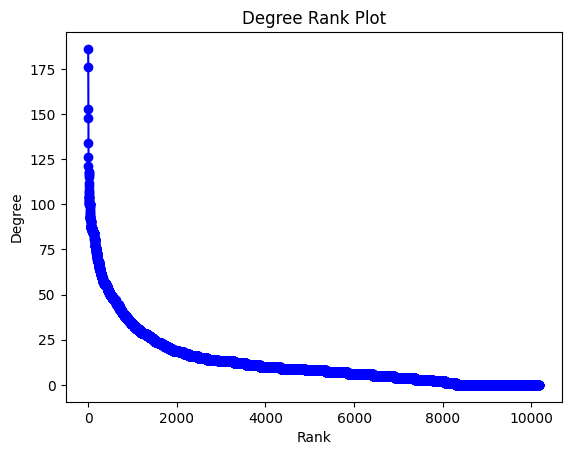

In [906]:
plt.plot(degree_sequence, "b-", marker="o")
plt.title("Degree Rank Plot")
plt.ylabel("Degree")
plt.xlabel("Rank")

Text(0.5, 1.0, 'CRORIS projects: Node Degree')

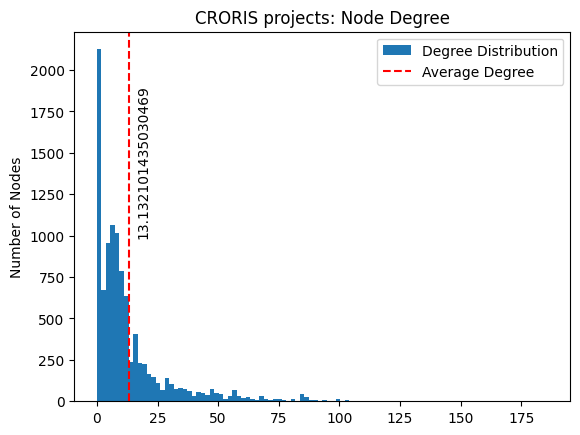

In [909]:
'''plot the degree distribution'''

plt.hist(degree_list,100,label='Degree Distribution')
plt.axvline(av_degree,color='r',linestyle='dashed',label='Average Degree')
#plt.text(av_degree+3,1000,av_degree,rotation=90)
plt.legend()
plt.ylabel('Number of Nodes')
plt.title('CRORIS projects: Node Degree')

### Clustering coefficient - structural holes
A low value of the clustering coefficient indicates the presence of a 'strucutral hole', i.e. a location in the network where there are links missing that would have otherwise been expected. Which typically indicates that a node is located on the outside of a cluster. It has been argued that individuals at strucutral holes in the network are more likely to come up with good ideas because, being at the edge of a tight cluster of nodes, they are exposed to a greater variety of different ideas from outside of that cluster (Burt, 2004).

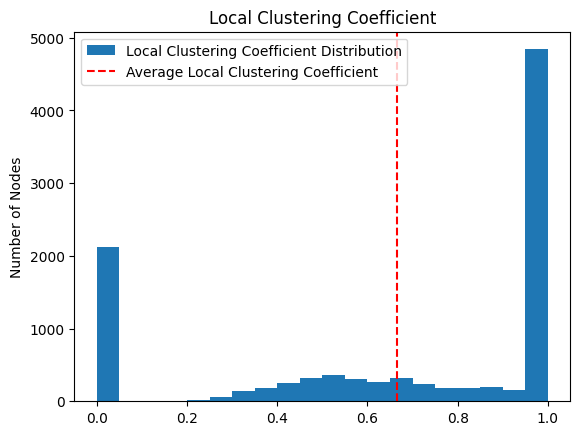

In [919]:
'''the average probability that a pair of node’s friends are also friends with each other. 
   In other words, it measures the extent to which any given node is located within a tight 
   'cluster' of neighbouring nodes.
   source - https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cluster.clustering.html#networkx.algorithms.cluster.clustering
'''

# compute the local clustering coefficient
local_clustering_coefficient = nx.algorithms.cluster.clustering(net)

# find the average clustering coefficient
av_local_clustering_coefficient = sum(local_clustering_coefficient.values())/len(local_clustering_coefficient)

# plot the local clustering coefficient distribution
plt.hist(local_clustering_coefficient.values(),20,label='Local Clustering Coefficient Distribution')
plt.axvline(av_local_clustering_coefficient,color='r',linestyle='dashed',label='Average Local Clustering Coefficient')
plt.legend()
plt.ylabel('Number of Nodes')
plt.title('Local Clustering Coefficient')
plt.show()

In [860]:
local_clustering_coefficient[29951]

0.7362637362637363

### Community Detection
A key aspect of network analysis is community detection. In a social network this is the idea that a large network can be broken down into smaller communinities/cliques.

In [920]:
from networkx.algorithms.community.modularity_max import greedy_modularity_communities

#preform the community detection
c = list(greedy_modularity_communities(net))

#Let's find out how many communities we detected
print(len(c))

2095


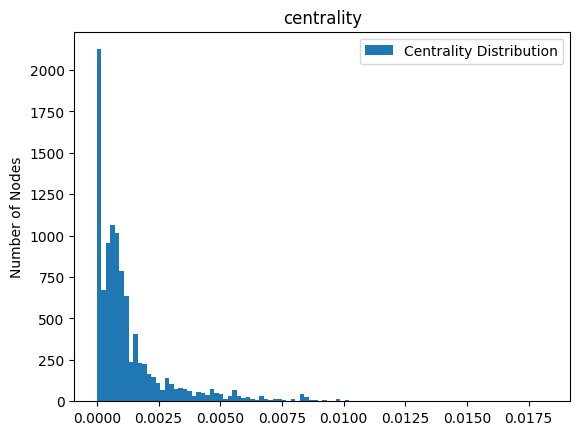

In [939]:
centrality = nx.degree_centrality(net)

# plot the centrality distribution
plt.hist(centrality.values(),100,label='Centrality Distribution')
#plt.axvline(av_local_clustering_coefficient,color='r',linestyle='dashed',label='Average Local Clustering Coefficient')
plt.legend()
plt.ylabel('Number of Nodes')
plt.title('centrality')
plt.show()

In [958]:
pos = nx.spring_layout(net)

plt.figure(2,figsize=(15,10))
plt.axis("off")
# draw graph
nx.draw_networkx_nodes(net, pos=pos, alpha=0.5, node_size=100, node_color='green')
nx.draw_networkx_edges(net, pos=pos, alpha=0.3)
#nx.draw_networkx_edge_labels(net, pos=pos, edge_labels=nx.get_edge_attributes(net,'projekt_id'))

# draw subgraph for highlights
nx.draw_networkx(net.subgraph(person), pos=pos, node_size=2000, node_color='red', 
                 font_family='sans-serif', font_weight='bold', font_size=12, font_color='black')
#nx.draw_networkx_nodes(net.subgraph(38162), pos=pos, node_size=2000, node_color='orange')

# most important
net_important = most_important(centered) # trimming
nx.draw_networkx_nodes(net_important, pos=pos, alpha=0.9, node_size=1000, node_color='pink')
nx.draw_networkx_labels(net_important, pos=pos, alpha=0.8, 
                        font_family='sans-serif', font_weight='normal', font_size=10, font_color='black')

plt.show()

KeyboardInterrupt: 

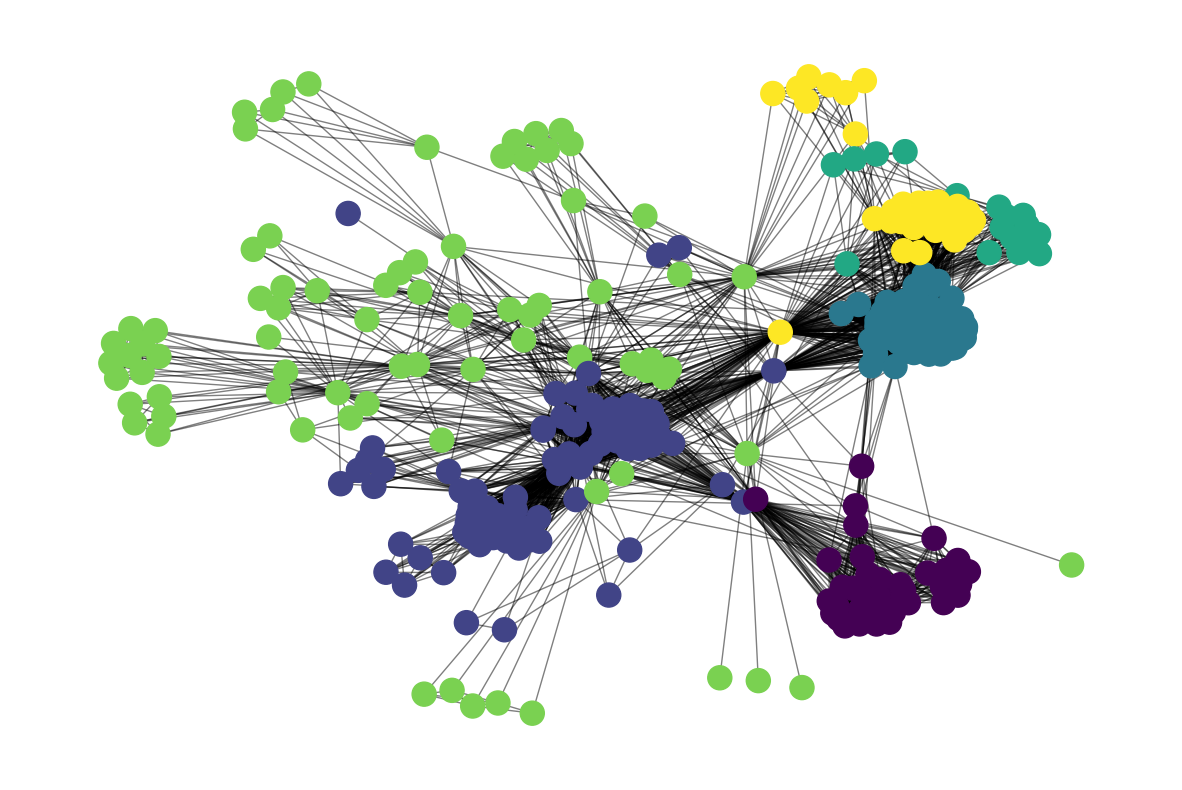

In [745]:
# Uses Louvain algorithm - References large networks. J. Stat. Mech 10008, 1-12(2008).
partition = community_louvain.best_partition(net)

# color the nodes according to their partition
plt.figure(2,figsize=(15,10))
plt.axis("off")
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(net, pos, partition.keys(), 
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(net, pos, alpha=0.5)
plt.show()

In [746]:
# https://notebook.community/eflegara/NetStruc/6.%20Community%20Detection
import operator
## For Hierarchical Clustering
## from scipy.cluster import hierarchy
## from scipy.spatial import distance

#order the dictionary by value, which is the edge betweeness of two nodes
ebet = nx.edge_betweenness_centrality(net)
sorted_ebet = sorted(ebet.items(), key=operator.itemgetter(1), reverse=True)
sorted_ebet[0:5]

[((10389, 39134), 0.0221437379233956),
 ((10389, 28416), 0.018148617436802777),
 ((10389, 39133), 0.01706903209403484),
 ((24602, 10389), 0.0169285418494968),
 ((10389, 15601), 0.01365421183347755)]

!pip install littleballoffur
from littleballoffur import DiffusionSampler